In [4]:

from astropy.io import fits
import pandas as pd
import numpy as np

# Get AstroNN VAC DR17 data: https://www.sdss4.org/dr17/data_access/value-added-catalogs/?vac_id=the-astronn-catalog-of-abundances,-distances,-and-ages-for-apogee-dr17-stars
astroNN_vac_dr17 = fits.open('path/to/apogee_astroNN-DR17.fits')
data = astroNN_vac_dr17[1].data
data_dict = {}
for name in data.names:
    col_data = data[name]
    if col_data.dtype.byteorder == '>':
        col_data = col_data.byteswap().newbyteorder()
    data_dict[name] = col_data
df_astroNN_vac_dr17 = pd.DataFrame(data_dict)
IDs_test = np.load('../../dataset/IDs_test.npy', allow_pickle=True)[:,0]
df_astroNN_vac_dr17_test = df_astroNN_vac_dr17[df_astroNN_vac_dr17['APOGEE_ID'].isin(IDs_test)]
#Remove duplicates based on lowest TEFF_ERR
df_astroNN_vac_dr17_test = df_astroNN_vac_dr17_test.sort_values(by=['APOGEE_ID', 'TEFF_ERR'], ascending=[True, True])
df_astroNN_vac_dr17_test_unique = df_astroNN_vac_dr17_test.drop_duplicates(subset=['APOGEE_ID'], keep='first')
df_astroNN_vac_dr17_test_unique = df_astroNN_vac_dr17_test_unique[['APOGEE_ID', 'TEFF', 'LOGG', 'O_H', 'MG_H', 'FE_H']]

# Need to convert O_H and MG_H to O_FE and MG_FE
df_astroNN_vac_dr17_test_unique['O_FE'] = df_astroNN_vac_dr17_test_unique['O_H'] - df_astroNN_vac_dr17_test_unique['FE_H']
df_astroNN_vac_dr17_test_unique['MG_FE'] = df_astroNN_vac_dr17_test_unique['MG_H'] - df_astroNN_vac_dr17_test_unique['FE_H']

df_astroNN_vac_dr17_test_unique = df_astroNN_vac_dr17_test_unique.rename(columns={'TEFF': 'TEFF_pred', 'LOGG': 'LOGG_pred', 'O_FE': 'O_FE_pred', 'MG_FE': 'MG_FE_pred', 'FE_H': 'FE_H_pred'})


In [5]:
labels_test = np.load('../../dataset/labels_test.npy')
label_columns = ['TEFF', 'LOGG','O_FE', 'MG_FE', 'FE_H']
df_labels_test = pd.DataFrame(labels_test, columns=label_columns)
df_labels_test['APOGEE_ID'] = IDs_test

df_vac_pred_actual = pd.merge(df_astroNN_vac_dr17_test_unique, df_labels_test, on='APOGEE_ID')
# #filter logg between 1.0 and 3.5
print(len(df_vac_pred_actual))
df_vac_pred_actual = df_vac_pred_actual[df_vac_pred_actual['LOGG'] < 3.5]
df_vac_pred_actual = df_vac_pred_actual[df_vac_pred_actual['LOGG'] > 1.0]
print(len(df_vac_pred_actual))

25681
16489


          Med Residual     MAD    RMSE
Teff    |   -0.926    |  10.231 |  31.122
Logg    |   -0.009    |   0.037 |   0.076
[O/Fe]  |   -0.007    |   0.020 |   0.037
[Mg/Fe] |    0.004    |   0.015 |   0.028
[Fe/H]  |    0.003    |   0.011 |   0.029


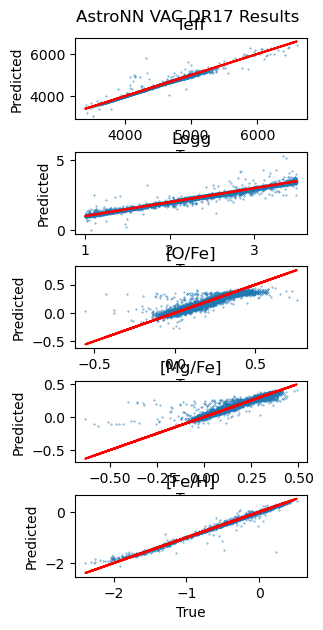

In [7]:
import matplotlib.pyplot as plt
from astropy.stats import mad_std as mad

def plot_results_vac(df, model_name):
    labels_titles = ['Teff', 'Logg','[O/Fe]', '[Mg/Fe]', '[Fe/H]']
    predictions = df[['TEFF_pred', 'LOGG_pred', 'O_FE_pred', 'MG_FE_pred', 'FE_H_pred']].to_numpy()
    labels = df[['TEFF', 'LOGG', 'O_FE', 'MG_FE', 'FE_H']].to_numpy()
    residuals = predictions - labels
    print(f"          Med Residual     MAD    RMSE")

    for i in range(5):
        med_res = np.nanmedian(residuals[:, i])
        mad_res = mad(np.ma.masked_invalid(residuals[:, i]))
        rms_res = np.sqrt(np.nanmean(residuals[:, i]**2))
        print(f"{labels_titles[i]:<7} |  {med_res:7.3f}    | {mad_res:7.3f} | {rms_res:7.3f}")
    fig, axs = plt.subplots(5, 1, figsize=(3, 7))
    for i in range(5):
        axs[i].scatter(labels[:, i], predictions[:, i], s=0.1)
        axs[i].plot(labels[:, i], labels[:, i], color='red')
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
        axs[i].set_title(labels_titles[i])
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(f"{model_name} Results", y=0.92)
    plt.show()

plot_results_vac(df_vac_pred_actual, "AstroNN VAC DR17")

In [11]:
# Load 1_basemodel_synthetic_epoch325_predictions.csv
basemodel_filename = '1_basemodel_synthetic_epoch325_predictions.csv'
df_basemodel = pd.read_csv(basemodel_filename)
print(f"Loaded basemodel file: {basemodel_filename}")

# Load 2_realfinetune_firsthalf_epoch_10_predictions.csv
realfinetune_filename = '2_realfinetune_firsthalf_epoch_10_predictions.csv'
df_realfinetune = pd.read_csv(realfinetune_filename)
print(f"Loaded real finetune file: {realfinetune_filename}")

# Apply logg cut to both dataframes
df_basemodel = df_basemodel[(df_basemodel['LOGG_actual'] >= 1.0) & (df_basemodel['LOGG_actual'] <= 3.5)]
df_realfinetune = df_realfinetune[(df_realfinetune['LOGG_actual'] >= 1.0) & (df_realfinetune['LOGG_actual'] <= 3.5)]

labels_titles = ['Teff', 'Logg', '[O/Fe]', '[Mg/Fe]', '[Fe/H]']
pred_columns = ['TEFF_pred', 'LOGG_pred', 'O_FE_pred', 'MG_FE_pred', 'FE_H_pred']
actual_columns = ['TEFF_actual', 'LOGG_actual', 'O_FE_actual', 'MG_FE_actual', 'FE_H_actual']

def print_stats(df, model_name):
    print(f"\n{model_name} Results:")
    print(f"          Med Residual     MAD    RMSE")
    
    for i, title in enumerate(labels_titles):
        residuals = df[pred_columns[i]] - df[actual_columns[i]]
        med_res = np.nanmedian(residuals)
        mad_res = mad(np.ma.masked_invalid(residuals))
        rms_res = np.sqrt(np.nanmean(residuals**2))
        print(f"{title:<7} |  {med_res:7.3f}    | {mad_res:7.3f} | {rms_res:7.3f}")

print_stats(df_basemodel, f"Basemodel ({basemodel_filename})")
print_stats(df_realfinetune, f"Real Finetune ({realfinetune_filename})")

Loaded basemodel file: 1_basemodel_synthetic_epoch325_predictions.csv
Loaded real finetune file: 2_realfinetune_firsthalf_epoch_10_predictions.csv

Basemodel (1_basemodel_synthetic_epoch325_predictions.csv) Results:
          Med Residual     MAD    RMSE
Teff    |  265.588    | 182.886 | 328.813
Logg    |    0.370    |   0.326 |   0.504
[O/Fe]  |   -0.020    |   0.038 |   0.054
[Mg/Fe] |   -0.026    |   0.034 |   0.052
[Fe/H]  |    0.059    |   0.048 |   0.087

Real Finetune (2_realfinetune_firsthalf_epoch_10_predictions.csv) Results:
          Med Residual     MAD    RMSE
Teff    |   10.705    |  19.104 |  37.665
Logg    |    0.019    |   0.056 |   0.092
[O/Fe]  |   -0.002    |   0.021 |   0.039
[Mg/Fe] |   -0.002    |   0.019 |   0.030
[Fe/H]  |    0.002    |   0.019 |   0.039
